#Important Information for Use

---



The execution of this Colab must be performed in 4 steps, as described in the Configurations section below.

To make it easier to locate the topics, search (CTRL+F) for the following keywords, including the slash:

/RESTART

/TRAINING

/TESTING

#Configuration

This notebook sets up the environment required to run the rtdetr_pytorch project.

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configure Execution (/config)

Configure o status da execução e: Runtime/Run All

In [ ]:
# Note: It is possible to execute only steps 1, 2, and 4.

# 1 = Download project and basic configurations (before restarting)

# RESTART THE ENVIRONMENT: Runtime/Restart session

# 2 = Additional configurations after restarting

# 3 = Training

# 4 = Testing

execution_status = 4



#Download Project and Prepare Dataset

In [ ]:
if execution_status == 1:
  import shutil
  import os


  def copy_directory(source, destination):
      try:
          # Create destination directory if it doesn't exist
          if not os.path.exists(destination):
              os.makedirs(destination)

          # Copy all contents from source to destination
          shutil.copytree(source, destination, dirs_exist_ok=True)
          print(f"Files successfully copied from '{source}' to '{destination}'")
      except Exception as e:
          print(f"Error while copying files: {e}")

  # # Source and destination paths
  source = "/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/rtdetr_pytorch"
  destination = "/content/rtdetr_pytorch"
  copy_directory(source, destination)

  source = "/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/artigo-referencia/rgb"
  destination = "/content/bkp_dataset/rgb"
  copy_directory(source, destination)

  source = "/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/artigo-referencia/img_list"
  destination = "/content/bkp_dataset/img_list"
  copy_directory(source, destination)

  source = "/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/artigo-referencia/bbox_txt"
  destination = "/content/bkp_dataset/bbox_txt"
  copy_directory(source, destination)



In [ ]:
if execution_status == 1:
  !pip install -r /content/rtdetr_pytorch/requirements.txt


#/RESTART

In [ ]:
# Restart CTRL+M

In [ ]:
if execution_status >= 2:
  #libraries general
  from datetime import datetime


In [ ]:
if execution_status >= 2:
  #global variables
  today_date = datetime.now().strftime("%Y-%m-%d")

#Settings

In [ ]:
use_augmentation = True

In [ ]:
if execution_status == 2:
  !nvidia-smi


#Verify images bboxes

In [ ]:
if execution_status == 2:
  import os

  def verify_images_and_bboxes(rgb_dir, bbox_dir):
      """
        Args:
            rgb_dir (str): Path to the RGB images directory.
            bbox_dir (str): Path to the bbox_txt files directory.

        Returns:
            None

      """
      #Get file names (without extensions) from both directories
      rgb_files = {os.path.splitext(f)[0] for f in os.listdir(rgb_dir) if os.path.isfile(os.path.join(rgb_dir, f))}
      bbox_files = {os.path.splitext(f)[0] for f in os.listdir(bbox_dir) if os.path.isfile(os.path.join(bbox_dir, f))}

      #Check which images are missing in bbox_txt
      missing_bboxes = rgb_files - bbox_files
      # Check which bbox_txt files are missing in rgb
      missing_images = bbox_files - rgb_files

      # Display results
      print("---- Image and BBox File Verification ----")
      if missing_bboxes:
          print(f"Images without corresponding bbox_txt files ({len(missing_bboxes)}):")
          for img in sorted(missing_bboxes):
              print(f"  - {img}")
      else:
          print("All images have corresponding bbox_txt files.")

      if missing_images:
          print(f"BBox files without corresponding images ({len(missing_images)}):")
          for bbox in sorted(missing_images):
              print(f"  - {bbox}")
      else:
          print("All bbox_txt files have corresponding images.")

  # Input directories
  rgb_dir = "/content/bkp_dataset/rgb"
  bbox_dir = "/content/bkp_dataset/bbox_txt"

  # Verify consistency between images and bbox files
  verify_images_and_bboxes(rgb_dir, bbox_dir)



## Prepare dataset for COCO format

In [ ]:
if execution_status == 2:
  import os
  import json
  import shutil
  from math import floor
  from random import shuffle

  # Base paths
  dataset_dir = "/content/bkp_dataset"
  rgb_dir = os.path.join(dataset_dir, "rgb")
  bbox_dir = os.path.join(dataset_dir, "bbox_txt")

  # Output directories
  output_annotations_dir = "/content/dataset/annotations"
  output_train_dir = "/content/dataset/train"
  output_val_dir = "/content/dataset/val"
  output_test_dir = "/content/dataset/test"

  # Remove and recreate directories
  def setup_directories(*dirs):
      for directory in dirs:
          if os.path.exists(directory):
              print(f"Removendo diretório: {directory}")
              shutil.rmtree(directory)
          os.makedirs(directory, exist_ok=True)

  setup_directories(output_annotations_dir, output_train_dir, output_val_dir, output_test_dir)

  # Function to load bounding boxes and validate dimensions
  def load_bboxes(bbox_file, img_width, img_height):
      bboxes = []
      with open(bbox_file, "r") as file:
          for line in file:
              try:
                  x_min, y_min, x_max, y_max = map(int, line.strip().split())
                  x_min = max(0, x_min)
                  y_min = max(0, y_min)
                  x_max = min(img_width, x_max)
                  y_max = min(img_height, y_max)
                  if x_max > x_min and y_max > y_min:  # Check if bbox is valid
                      width = x_max - x_min
                      height = y_max - y_min
                      bboxes.append({
                          "bbox": [x_min, y_min, width, height],
                          "area": width * height,
                          "iscrowd": 0,
                          "segmentation": [
                              [x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max]
                          ]  # Rectangular polygon
                      })
              except ValueError:
                  print(f"Erro ao processar linha em {bbox_file}: {line.strip()}")
      return bboxes


  # Matching verification between images and bounding boxes
  def match_image_bbox_files(rgb_dir, bbox_dir):
      rgb_files = {os.path.splitext(f)[0] for f in os.listdir(rgb_dir) if f.endswith(".png")}
      bbox_files = {os.path.splitext(f)[0] for f in os.listdir(bbox_dir) if f.endswith(".txt")}
      matched_files = rgb_files & bbox_files
      missing_bboxes = rgb_files - bbox_files
      missing_images = bbox_files - rgb_files

      if missing_bboxes:
          print(f"Images without bounding boxes ({len(missing_bboxes)}): {sorted(missing_bboxes)}")
      if missing_images:
          print(f"Bboxes without corresponding images ({len(missing_images)}): {sorted(missing_images)}")

      return list(matched_files)

  # Create dataset in COCO format
  def create_coco_dataset(image_files, split_name, output_dir):
      coco_dataset = {
          "info": {
              "description": f"COCO Dataset for {split_name}",
              "version": "1.0",
              "year": 2024,
              "contributor": "Script Generator",
              "date_created": "2024-11-27"
          },
          "licenses": [{"id": 1, "name": "Unknown", "url": ""}],
          "images": [],
          "annotations": [],
          "categories": [{"id": 0, "name": "tree", "supercategory": "nature"}] # Adjusted category
      }

      annotation_id = 1
      for img_id, img_name in enumerate(image_files, start=1):
          img_path = os.path.join(rgb_dir, f"{img_name}.png")
          bbox_file = os.path.join(bbox_dir, f"{img_name}.txt")

          if not os.path.exists(img_path):
              print(f"Image not found: {img_path}. Skipping.")
              continue
          if not os.path.exists(bbox_file):
              print(f"Bbox file not found: {bbox_file}. Skipping.")
              continue

          # Copy image to output directory
          dest_img_path = os.path.join(output_dir, f"{img_name}.png")
          shutil.copy(img_path, dest_img_path)

          # Add image entry to the dataset
          coco_dataset["images"].append({
              "id": img_id,
              "file_name": f"{img_name}.png",
              "height": 512,
              "width": 512,
              "license": 1,
              "date_captured": "2024-11-27",
              "coco_url": "",
              "flickr_url": ""
          })

          # Load and add bounding boxes
          bboxes = load_bboxes(bbox_file, 512, 512)
          for bbox in bboxes:
              bbox.update({
                  "id": annotation_id,
                  "image_id": img_id,
                  "category_id": 0
              })
              coco_dataset["annotations"].append(bbox)
              annotation_id += 1

      return validate_coco_dataset(coco_dataset)

  # Function to validate the COCO dataset
  def validate_coco_dataset(coco_dataset):
      # Validate `category_id`
      valid_category_ids = {category["id"] for category in coco_dataset["categories"]}
      coco_dataset["annotations"] = [
          ann for ann in coco_dataset["annotations"]
          if ann["category_id"] in valid_category_ids
      ]

      # Validate bounding boxes
      def is_valid_bbox(bbox):
          _, _, width, height = bbox
          return width > 0 and height > 0

      coco_dataset["annotations"] = [
          ann for ann in coco_dataset["annotations"]
          if is_valid_bbox(ann["bbox"])
      ]

      # Validate `image_id`
      valid_image_ids = {image["id"] for image in coco_dataset["images"]}
      coco_dataset["annotations"] = [
          ann for ann in coco_dataset["annotations"]
          if ann["image_id"] in valid_image_ids
      ]

      return coco_dataset


  def save_coco_json(coco_data, output_file):
      with open(output_file, "w") as file:
          json.dump(coco_data, file, indent=4)

  # Prepare images and split into splits
  matched_files = match_image_bbox_files(rgb_dir, bbox_dir)
  shuffle(matched_files)

  total_images = len(matched_files)

  if use_augmentation == True:   # if  using data augmentation, 0.5
    train_split = floor(total_images * 0.5)
    val_split = floor(total_images * 0.25)
  else:
    train_split = floor(total_images * 0.6)
    val_split = floor(total_images * 0.2)

  train_images = matched_files[:train_split]
  val_images = matched_files[train_split:train_split + val_split]
  test_images = matched_files[train_split + val_split:]

  # Create COCO datasets
  train_coco = create_coco_dataset(train_images, "train", output_train_dir)
  val_coco = create_coco_dataset(val_images, "val", output_val_dir)
  test_coco = create_coco_dataset(test_images, "test", output_test_dir)

  # Save JSONs
  save_coco_json(train_coco, os.path.join(output_annotations_dir, "instances_train.json"))
  save_coco_json(val_coco, os.path.join(output_annotations_dir, "instances_val.json"))
  save_coco_json(test_coco, os.path.join(output_annotations_dir, "instances_test.json"))

  print("Dataset successfully prepared.")
  print(f"Train: {len(train_images)} images.")
  print(f"Validation: {len(val_images)} images.")
  print(f"Test: {len(test_images)} images.")


# Verifications

In [ ]:
if execution_status >= 2:
  import os
  import json

  def count_files_and_instances(train_dir, val_dir, test_dir, annotations_dir):
      """
      Counts the number of files in the output directories (train, val, test) and
      the total instances in each JSON file (instances_train.json, instances_val.json, instances_test.json).
      Displays the overall total of files and instances.

      Args:
          train_dir (str): Path to the training directory.
          val_dir (str): Path to the validation directory.
          test_dir (str): Path to the testing directory.
          annotations_dir (str): Path to the directory containing the JSON files.

      Returns:
          None
      """
      # Count files in each directory
      directories = {"train": train_dir, "val": val_dir, "test": test_dir}
      total_files = 0
      print("File count in each folder:")
      for name, directory in directories.items():
          if os.path.exists(directory):
              file_count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
              total_files += file_count
              print(f"{name}: {file_count} files")
          else:
              print(f"{name}: 0 files (directory not found)")

      print(f"Overall total files: {total_files} files")

      # Count instances in each JSON
      instance_counts = {}
      total_instances = 0
      files_in_order = ["instances_train.json", "instances_val.json", "instances_test.json"]

      for filename in files_in_order:
          file_path = os.path.join(annotations_dir, filename)
          if os.path.exists(file_path):  #  Check if the file exists
              with open(file_path, "r") as json_file:
                  data = json.load(json_file)
                  count = len(data.get("annotations", []))  # Count annotations
                  instance_counts[filename] = count
                  total_instances += count
                  print(f"{filename}: {count} instances")
          else:
              print(f"{filename}: 0 instances (file not found)")

      print(f"\nOverall total instances: {total_instances} instances")



  # Directory paths
  output_train_dir = "/content/dataset/train"
  output_val_dir = "/content/dataset/val"
  output_test_dir = "/content/dataset/test"
  annotations_dir = "/content/dataset/annotations"

  count_files_and_instances(output_train_dir, output_val_dir, output_test_dir, annotations_dir)


File count in each folder:
train: 550 files
val: 55 files
test: 55 files
Overall total files: 660 files
instances_train.json: 7893 instances
instances_val.json: 895 instances
instances_test.json: 834 instances

Overall total instances: 9622 instances


# Continue validations

In [ ]:
if execution_status == 2:
  import torch
  print(torch.cuda.is_available())
  print(torch.cuda.get_device_name(0))  # Should display "NVIDIA A100-SXM4-40GB"


In [ ]:
if execution_status == 2:
  import json

  def check_category_ids(annotation_file, num_classes):
      with open(annotation_file, "r") as f:
          data = json.load(f)

      categories = {category["id"]: category["name"] for category in data.get("categories", [])}
      annotations = data.get("annotations", [])

      invalid_ids = []
      for annotation in annotations:
          if annotation["category_id"] < 0 or annotation["category_id"] > num_classes:
              invalid_ids.append(annotation["category_id"])

      if invalid_ids:
          print(f"Category IDs out of range [1, {num_classes}]: {set(invalid_ids)}")
      else:
          print(f"All category IDs are within the range [1, {num_classes}]")

  # Replace with the path to the training JSON file
  annotation_file = "/content/dataset/annotations/instances_train.json"

  # Check with `num_classes = 1` for a single class "tree"
  check_category_ids(annotation_file, num_classes=1)


In [ ]:
if execution_status == 2:
  def check_bboxes(annotation_file):
      """
      # Checks if all bounding boxes are valid.
      """
      with open(annotation_file, "r") as f:
          data = json.load(f)

      invalid_bboxes = []
      for annotation in data.get("annotations", []):
          x, y, w, h = annotation["bbox"]
          if w <= 0 or h <= 0:
              invalid_bboxes.append(annotation["id"])

      if invalid_bboxes:
          print(f"Invalid BBoxes found in IDs: {invalid_bboxes}")
      else:
          print("All bounding boxes are valid.")

  # Verify the training file
  annotation_file = "/content/dataset/annotations/instances_train.json"
  check_bboxes(annotation_file)


In [ ]:
if execution_status == 2:
  !ls /content/dataset/train | wc -l

In [ ]:
if execution_status == 2:

  def check_images_with_annotations(annotation_file, image_dir):
      """
      Checks if all images have at least one annotation and displays the total annotations grouped by file name.
      """
      with open(annotation_file, "r") as f:
          data = json.load(f)

      # Create mapping of IDs to file names
      id_to_file_name = {img["id"]: img["file_name"] for img in data.get("images", [])}

      # Check for duplicates or inconsistencies in the JSON
      print(f"Number of entries in the 'images' section: {len(data.get('images', []))}")
      annotation_ids = {ann["image_id"] for ann in data.get("annotations", [])}
      image_ids = {img["id"] for img in data.get("images", [])}

      # Files missing in the JSON
      import os
      actual_files = os.listdir(image_dir)
      json_files = [img["file_name"] for img in data.get("images", [])]
      missing_files = set(actual_files) - set(json_files)
      if missing_files:
          print(f"Files present in the directory but missing in the JSON: {missing_files}")

      # IDs ausentes entre anotações e imagens
      missing_ids = annotation_ids - image_ids
      if missing_ids:
          print(f"IDs of images in annotations but missing in the 'images' section: {missing_ids}")

      # Count annotations per file
      annotations_by_file_name = {}
      for ann in data.get("annotations", []):
          file_name = id_to_file_name.get(ann["image_id"], "Desconhecido")
          if file_name not in annotations_by_file_name:
              annotations_by_file_name[file_name] = 0
          annotations_by_file_name[file_name] += 1

      print(f"Total files in the dataset: {len(id_to_file_name)}")
      print("Total annotations grouped by file name:")
      for file_name, count in annotations_by_file_name.items():
          print(f"File {file_name}: {count} annotations")

  annotation_file = "/content/dataset/annotations/instances_train.json"
  check_images_with_annotations(annotation_file, "/content/dataset/train")


In [ ]:
import os
import json
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import json
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import json
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def visualize_bounding_boxes_grouped(annotation_file, image_folder, num_images=None, specific_image_name=None):
    """
    Visualize images with all bounding boxes grouped.

    Args:
        annotation_file (str): Path to the JSON annotation file in COCO format.
        image_folder (str): Path to the directory containing the images.
        num_images (int, optional): Number of images to visualize randomly. Displays all if not specified.
        specific_image_name (str, optional): Specific image name to be visualized. Ignores `num_images` if provided.
    """
    with open(annotation_file, "r") as f:
        data = json.load(f)

    # Map image IDs to information
    image_info = {img["id"]: img for img in data.get("images", [])}
    file_name_to_id = {img["file_name"]: img["id"] for img in data.get("images", [])}

    # Group annotations by image
    annotations_by_image = {}
    for annotation in data.get("annotations", []):
        image_id = annotation["image_id"]
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(annotation)

    # Check if a specific name was provided
    if specific_image_name is not None:
        if specific_image_name not in file_name_to_id:
            print(f"Image name {specific_image_name} not found in annotations.")
            return
        image_ids = [file_name_to_id[specific_image_name]]
    else:
        # Select image IDs to visualize
        image_ids = list(annotations_by_image.keys())
        if num_images is not None and num_images < len(image_ids):
            image_ids = random.sample(image_ids, num_images)

    for image_id in image_ids:
        # Get image information
        img_info = image_info.get(image_id)
        if not img_info:
            print(f"Image information not found for ID: {image_id}")
            continue

        img_path = os.path.join(image_folder, img_info["file_name"])
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        # Open image
        img = Image.open(img_path)
        draw = ImageDraw.Draw(img)

        # Draw all bounding boxes for this image
        for annotation in annotations_by_image[image_id]:
            bbox = annotation["bbox"]  # [x_min, y_min, width, height]
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            draw.rectangle([x_min, y_min, x_max, y_max], outline="white", width=5)

        # Display the image with Matplotlib
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image: {img_info['file_name']}")
        plt.show()


if execution_status == 2:
  annotation_file = "/content/dataset/annotations/instances_train.json"
  image_folder = "/content/dataset/train/"

  visualize_bounding_boxes_grouped(annotation_file, image_folder, num_images=5)


In [ ]:
def make_dataset_import(use_augmentation):
  if use_augmentation:
      zip_file_name = "dataset_experiment_with_data_augmentation.zip"
      type_train = "with_augmentation_hvsr"  # with data augmentation
  else:
      zip_file_name = "dataset_experiment_without_data_augmentation.zip"
      type_train = "without_augmentation"  # with data augmentation


  ![ -d "/content/temp_unzip" ] && rm -rf /content/temp_unzip
  ![ -d "/content/dataset" ] && rm -rf /content/dataset
  !mkdir -p /content/dataset

  source_path = f"/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/results_train/{type_train}/dataset_experiments/{zip_file_name}"

  print(source_path)

  !cp "{source_path}" "/content/"

  zip_file_path = f"/content/{zip_file_name}"
  !unzip -o "{zip_file_path}" -d "/content/temp_unzip"

  !mv /content/temp_unzip/content/dataset /content/

  ![ -d "/content/temp_unzip" ] && rm -rf /content/temp_unzip
  !rm -f /content/dataset*.zip

# if execution_status == 2:
#   make_dataset_import(use_augmentation = True) #import base dataset

#Data augmentation

In [ ]:
if execution_status == 2:

  if use_augmentation == True:
    import os
    import json
    import cv2
    import imgaug.augmenters as iaa
    from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


    def process_dataset_with_imgaug(annotation_path, image_dir, augmenter, operation_name):
        """
        Processes a COCO dataset with imgaug to apply augmentation to images and bounding boxes.

        Args:
            annotation_path (str): Path to the COCO JSON file.
            image_dir (str): Directory containing the images.
            augmenter (iaa.Sequential): imgaug augmentation pipeline.
            operation_name (str): Name of the augmentation operation to use as a prefix for the files.
        """
        # Load the COCO JSON file
        try:
            with open(annotation_path, "r") as f:
                coco_data = json.load(f)
        except Exception as e:
            print(f"Error loading the annotation file: {annotation_path}. Details: {e}")
            return

        annotations = coco_data["annotations"]
        images = coco_data["images"]

        # Lists to track status
        total_images = [img["file_name"] for img in images if not img["file_name"].startswith("aug_")]
        processed_images = []
        failed_images = {}

        new_images = []
        new_annotations = []
        ann_id = max(ann["id"] for ann in annotations) + 1
        img_id = max(img["id"] for img in images) + 1

        for image_info in images:
            # Skip already augmented images
            if image_info["file_name"].startswith("aug_"):
                continue

            image_path = os.path.join(image_dir, image_info["file_name"])
            try:
                image = cv2.imread(image_path)
                if image is None:
                    failed_images[image_info["file_name"]] = "Error loading the image."
                    continue
            except Exception as e:
                failed_images[image_info["file_name"]] = f"Error processing the image. Details: {e}"
                continue

            # Collect bounding boxes
            try:
                bboxes = []
                for ann in annotations:
                    if ann["image_id"] == image_info["id"]:
                        x_min, y_min, width, height = ann["bbox"]
                        x_max = x_min + width
                        y_max = y_min + height
                        bboxes.append(BoundingBox(x1=x_min, y1=y_min, x2=x_max, y2=y_max))

                bbs_on_image = BoundingBoxesOnImage(bboxes, shape=image.shape)
            except Exception as e:
                failed_images[image_info["file_name"]] = f"Error creating bounding boxes. Details: {e}"
                continue


            try:
                augmented_image, augmented_bbs = augmenter(image=image, bounding_boxes=bbs_on_image)
                augmented_bbs = augmented_bbs.clip_out_of_image()
            except Exception as e:
                failed_images[image_info["file_name"]] = f"Error applying augmentation '{operation_name}'. Details: {e}"
                continue

            # Generate the augmented file name
            augmented_file_name = f"aug_{operation_name}_{image_info['file_name']}"

            try:
                augmented_image_path = os.path.join(image_dir, augmented_file_name)
                cv2.imwrite(augmented_image_path, augmented_image)
            except Exception as e:
                failed_images[image_info["file_name"]] = f"Error saving the augmented image. Details: {e}"
                continue

            # Add new image to the JSON
            try:
                new_image_info = image_info.copy()
                new_image_info["id"] = img_id
                new_image_info["file_name"] = augmented_file_name
                new_images.append(new_image_info)

                # Add new annotations to the JSON
                for bbox in augmented_bbs.bounding_boxes:
                    x_min = bbox.x1
                    y_min = bbox.y1
                    x_max = bbox.x2
                    y_max = bbox.y2
                    new_annotation = {
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": 0,  # Fixed category
                        "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                        "area": (x_max - x_min) * (y_max - y_min),
                        "iscrowd": 0
                    }
                    new_annotations.append(new_annotation)
                    ann_id += 1

                processed_images.append(image_info["file_name"])
                img_id += 1
            except Exception as e:
                failed_images[image_info["file_name"]] = f"Error adding annotations to the JSON. Details: {e}"
                continue

        # Update the JSON with new images and annotations
        try:
            coco_data["images"].extend(new_images)
            coco_data["annotations"].extend(new_annotations)

            with open(annotation_path, "w") as f:
                json.dump(coco_data, f)
        except Exception as e:
            print(f"Error updating the JSON file: {annotation_path}. Details: {e}")

        # Final report
        print("\nProcessing summary:")
        print(f"Total expected images: {len(total_images)}")
        print(f"Successfully processed images: {len(processed_images)}")
        print(f"Failed images: {len(failed_images)}")


        if failed_images:
            print("\nFailed files:")
            for file_name, reason in failed_images.items():
                print(f"- {file_name}: {reason}")



    # Dataset configuration
    datasets = [
        {"annotation": "/content/dataset/annotations/instances_train.json", "directory": "/content/dataset/train"},
    ]



    from imgaug import augmenters as iaa

    operations = {
        "flip_horizontal": iaa.Sequential([iaa.Fliplr(1.0)]),  # Horizontal flip (100%)
        "flip_vertical": iaa.Sequential([iaa.Flipud(1.0)]),  # Vertical flip (100%)
        "scale_translate": iaa.Sequential([
            iaa.Affine(translate_px={"x": (-40, 40), "y": (-40, 40)}, scale=(0.8, 1.2))
        ]),
        "rotate": iaa.Sequential([iaa.Affine(rotate=(-45, 45))]),
    }

    # Process each dataset with each operation
    for operation_name, augmenter in operations.items():
        for dataset in datasets:
            annotation_path = dataset["annotation"]
            image_directory = dataset["directory"]
            print(f"Processing {annotation_path} with operation {operation_name}")
            process_dataset_with_imgaug(annotation_path, image_directory, augmenter, operation_name)
            print(f"Completed {annotation_path} with operation {operation_name}")

In [ ]:
if execution_status == 2:
  count_files_and_instances(output_train_dir, output_val_dir, output_test_dir, annotations_dir)

In [ ]:
if execution_status == 2:

  if use_augmentation == True:
    name = "112" # Associate any image ... one that is in the training set

    # Visualize a specific image by its ID
    visualize_bounding_boxes_grouped(
        annotation_file="/content/dataset/annotations/instances_train.json",
        image_folder="/content/dataset/train/",
        specific_image_name=f"{name}.png"
    )

    visualize_bounding_boxes_grouped(
        annotation_file="/content/dataset/annotations/instances_train.json",
        image_folder="/content/dataset/train/",
        specific_image_name=f"aug_flip_horizontal_{name}.png"
    )

    visualize_bounding_boxes_grouped(
        annotation_file="/content/dataset/annotations/instances_train.json",
        image_folder="/content/dataset/train/",
        specific_image_name=f"aug_flip_vertical_{name}.png"
    )

    visualize_bounding_boxes_grouped(
        annotation_file="/content/dataset/annotations/instances_train.json",
        image_folder="/content/dataset/train/",
        specific_image_name=f"aug_scale_translate_{name}.png"
    )


    visualize_bounding_boxes_grouped(
        annotation_file="/content/dataset/annotations/instances_train.json",
        image_folder="/content/dataset/train/",
        specific_image_name=f"aug_rotate_{name}.png"
    )

In [ ]:
def validate_dataset(annotation_file, num_classes=1):
      """
      Validates a COCO dataset to check categories, bounding boxes, and orphan annotations.

      Args:
          annotation_file (str): Path to the COCO JSON file.
          num_classes (int): Number of classes in the dataset (default: 1).

      Returns:
          dict: Dictionary containing identified errors.

      """
      import json

      with open(annotation_file, "r") as f:
          data = json.load(f)

      # IDs de categoria válidos (para uma categoria fixa com id 0)
      valid_category_ids = {i for i in range(num_classes)}

      errors = {
          "invalid_categories": [],
          "invalid_bboxes": [],
          "orphan_annotations": []
      }

      # Check categories
      for annotation in data["annotations"]:
          if annotation["category_id"] not in valid_category_ids:
              errors["invalid_categories"].append(annotation)

          x, y, w, h = annotation["bbox"]
          if w <= 0 or h <= 0:
              errors["invalid_bboxes"].append(annotation)

      # Check annotations without images
      image_ids = {image["id"] for image in data["images"]}
      for annotation in data["annotations"]:
          if annotation["image_id"] not in image_ids:
              errors["orphan_annotations"].append(annotation)

      # Display error messages
      if errors["invalid_categories"]:
          print(f"Invalid categories: {len(errors['invalid_categories'])}")
      if errors["invalid_bboxes"]:
          print(f"Invalid bounding boxes: {len(errors['invalid_bboxes'])}")
      if errors["orphan_annotations"]:
          print(f"Annotations without images: {len(errors['orphan_annotations'])}")

      return errors

if execution_status == 2:

  # Paths to the annotation files
  train_annotation_file = "/content/dataset/annotations/instances_train.json"
  val_annotation_file = "/content/dataset/annotations/instances_val.json"
  test_annotation_file = "/content/dataset/annotations/instances_test.json"

  # Number of expected classes in the dataset
  num_classes = 1

  # Validate annotation files
  print("--- Checking train ---")
  train_errors = validate_dataset(train_annotation_file, num_classes)
  if not any(train_errors.values()):
      print("Train dataset successfully verified!")
  else:
      print("Errors found in the train dataset!")

  print("\n--- Checking val ---")
  val_errors = validate_dataset(val_annotation_file, num_classes)
  if not any(val_errors.values()):
      print("Val dataset successfully verified!")
  else:
      print("Errors found in the val dataset!")

  print("\n--- Checking test ---")
  test_errors = validate_dataset(test_annotation_file, num_classes)
  if not any(test_errors.values()):
      print("Test dataset successfully verified!")
  else:
      print("Errors found in the test dataset!")


##Back up the dataset with the divisions to perform later tests

Backs up the dataset prepared for training with the trai, val and test divisions. It will be transferred to Google Drive.

In [ ]:
# if execution_status == 2:
#     # Define o nome do arquivo com base no valor de use_augmentation
#     if use_augmentation:
#         zip_file_name = "dataset_experiment_with_data_augmentation.zip"
#     else:
#         zip_file_name = "dataset_experiment_without_data_augmentation.zip"

#     # Remove qualquer arquivo ZIP existente correspondente
#     !rm -f /content/dataset*.zip

#     # Caminhos para o diretório de destino e o arquivo ZIP
#     destination_dir = f"/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/results_train/dataset_experiments"
#     zip_file_path = f"/content/{zip_file_name}"

#     # Criar o arquivo ZIP
#     os.system(f"zip -r {zip_file_path} /content/dataset")

#     # Copiar o arquivo ZIP para o diretório de destino
#     os.system(f"cp {zip_file_path} {destination_dir}/")


In [ ]:
# make_dataset_import(use_augmentation=False)

# output_train_dir = "/content/dataset/train"
# output_val_dir = "/content/dataset/val"
# output_test_dir = "/content/dataset/test"
# annotations_dir = "/content/dataset/annotations"

# count_files_and_instances(output_train_dir, output_val_dir, output_test_dir, annotations_dir)

#/TRAINING

In [ ]:
if execution_status == 3:
  !pip show torch
  !pip show torchvision


In [ ]:
if execution_status == 3:
  output_train_dir = "/content/dataset/train"
  output_val_dir = "/content/dataset/val"
  output_test_dir = "/content/dataset/test"
  annotations_dir = "/content/dataset/annotations"

  count_files_and_instances(output_train_dir, output_val_dir, output_test_dir, annotations_dir)

if you are going to train from a checkpoint.. uncomment

In [ ]:
# # import os
# # import shutil
# # from zipfile import ZipFile

# # Path to the original ZIP file
# zip_file_path = "/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/results_train/results_train_rtdetr_dla34_6x_coco_2024-11-30.zip"

# # Destination directory
# destination_dir = "/content/continue"

# # Check if the ZIP file exists
# if not os.path.exists(zip_file_path):
#     print(f"File not found: {zip_file_path}")
#     exit()

# # Create the destination folder if it doesn't exist
# if not os.path.exists(destination_dir):
#     os.makedirs(destination_dir)
#     print(f"Folder created: {destination_dir}")

# # Copy the ZIP file to the destination folder
# destination_zip_path = os.path.join(destination_dir, os.path.basename(zip_file_path))
# shutil.copy2(zip_file_path, destination_zip_path)
# print(f"File copied to: {destination_zip_path}")

# # Extract the ZIP file into the destination folder
# with ZipFile(destination_zip_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_dir)
#     print(f"File extracted to: {destination_dir}")

In [ ]:
if execution_status == 3:
  import json

  def get_best_checkpoint(log_path):
      """
      Analyzes the log file to identify the best checkpoint based on the test_coco_eval_bbox metric.

      Args:
          log_path (str): Path to the log file.

      Returns:
          dict: A dictionary containing the best checkpoint, its score, and the corresponding epoch.
      """
      best_epoch = None
      best_score = -float('inf')
      best_checkpoint = None

      try:
          with open(log_path, 'r') as log_file:
              for line in log_file:
                  # Attempt to load each line as JSON
                  try:
                      log_data = json.loads(line.strip())

                      # Check if the test_coco_eval_bbox metric is available
                      if "test_coco_eval_bbox" in log_data and "epoch" in log_data:
                          # Calculate the average score of test_coco_eval_bbox
                          score = sum(log_data["test_coco_eval_bbox"]) / len(log_data["test_coco_eval_bbox"])

                          # Update the best score if this one is higher
                          if score > best_score:
                              best_score = score
                              best_epoch = log_data["epoch"]
                              best_checkpoint = f"checkpoint{str(best_epoch).zfill(4)}.pth"
                  except json.JSONDecodeError:
                      # Skip lines that cannot be parsed as JSON
                      continue

          return {
              "best_checkpoint": best_checkpoint,
              "best_score": best_score,
              "best_epoch": best_epoch
          }
      except FileNotFoundError:
          print("Log file not found.")
          return None



In [ ]:
if execution_status == 3:
  # Train the network using multiple backbones
  import os

  models = [
        "rtdetr_dla34_6x_coco",
        "rtdetr_r101vd_6x_coco",
         "rtdetr_r18vd_6x_coco",
        "rtdetr_r34vd_6x_coco",
        "rtdetr_r50vd_6x_coco",
        "rtdetr_r50vd_m_6x_coco",
        "rtdetr_regnet_6x_coco"
  ]

  destination_dir = "/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/results_train"

  for model in models:
      print(f"Training model: {model}...")

      !CUDA_VISIBLE_DEVICES=0 python /content/rtdetr_pytorch/tools/train.py \
        -c /content/rtdetr_pytorch/configs/rtdetr/{model}.yml

      log_path = f"/content/output/{model}/log.txt"

      best_checkpoint_info = get_best_checkpoint(log_path)

      if best_checkpoint_info:
          print("Best Checkpoint:")
          print(f"File: {best_checkpoint_info['best_checkpoint']}")
          print(f"Average Score: {best_checkpoint_info['best_score']}")
          print(f"Epoch: {best_checkpoint_info['best_epoch']}")

          print(f"running command: mv /content/output/{model}/{best_checkpoint_info['best_checkpoint']} /content/output/{model}/checkpoint_best.pth")

          os.system(f"mv /content/output/{model}/{best_checkpoint_info['best_checkpoint']} /content/output/{model}/checkpoint_best.pth")

          os.system(f"find /content/output/{model}/ -type f -name 'checkpoint0*.pth' -delete")

          zip_file_path = f"/content/results_train_{model}_{today_date}.zip"
          os.system(f"zip -r {zip_file_path} /content/output/{model}")

          os.system(f"cp {zip_file_path} {destination_dir}/")

          os.system(f"rm {zip_file_path}")
          print(f"ZIP file copied to Google Drive at: {destination_dir}/results_train_{model}_{today_date}.zip")

          !rm -rf /content/output/{model}



  # !CUDA_LAUNCH_BLOCKING=1 python /content/rtdetr_pytorch/tools/train.py \
  #       -c /content/rtdetr_pytorch/configs/rtdetr/{modelo}.yml \
  #       -r /content/continue/content/output/{modelo}/checkpoint.pth




#/TESTING

In [ ]:
if execution_status == 4:
  !rm -rf /content/output
  !rm -rf /content/analysis
  !rm -rf /content/results
  !rm -rf /content/dataset

In [ ]:
if execution_status == 4:
  make_dataset_import(use_augmentation = True)

  #check
  if execution_status == 4:
    output_train_dir = "/content/dataset/train"
    output_val_dir = "/content/dataset/val"
    output_test_dir = "/content/dataset/test"
    annotations_dir = "/content/dataset/annotations"

    count_files_and_instances(output_train_dir, output_val_dir, output_test_dir, annotations_dir)


/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/results_train/with_augmentation_hvsr/dataset_experiments/dataset_experiment_with_data_augmentation.zip
Archive:  /content/dataset_experiment_with_data_augmentation.zip
   creating: /content/temp_unzip/content/dataset/
   creating: /content/temp_unzip/content/dataset/train/
  inflating: /content/temp_unzip/content/dataset/train/aug_rotate_26.png  
  inflating: /content/temp_unzip/content/dataset/train/aug_flip_vertical_217.png  
  inflating: /content/temp_unzip/content/dataset/train/aug_scale_translate_20.png  
  inflating: /content/temp_unzip/content/dataset/train/aug_flip_horizontal_54.png  
  inflating: /content/temp_unzip/content/dataset/train/aug_flip_vertical_43.png  
  inflating: /content/temp_unzip/content/dataset/train/215.png  
  inflating: /content/temp_unzip/content/dataset/train/90.png  
  inflating: /content/temp_unzip/content/dataset/train/aug_scale_translate_158.png  
  inflating: /content/temp_unzip/content/

In [ ]:
# if execution_status == 4:
#   import os
#   import json

#   # Paths to the image directory and the annotation file
#   image_folder = "/content/dataset/test/"
#   annotation_file = "/content/dataset/annotations/instances_test.json"

#   # Load annotations
#   with open(annotation_file, "r") as f:
#       annotations = json.load(f)

#   # Build a map of annotations grouped by image
#   annotations_by_image = {}
#   for annotation in annotations["annotations"]:
#       image_id = annotation["image_id"]
#       if image_id not in annotations_by_image:
#           annotations_by_image[image_id] = []
#       annotations_by_image[image_id].append(annotation)

#   # Map IDs to image names
#   image_id_to_name = {img["id"]: img["file_name"] for img in annotations["images"]}

#   # List all files in the image directory
#   image_files = [f for f in os.listdir(image_folder) if f.endswith(".png")]

#   # Visualize the images with annotations
#   for image_name in image_files:
#       # Find the image ID
#       image_id = next(
#           (id for id, name in image_id_to_name.items() if name == image_name),
#           None
#       )
#       if image_id is None:
#           print(f"Image {image_name} not found in the JSON.")
#           continue

#       # Ensure there are annotations for the image
#       if image_id not in annotations_by_image:
#           print(f"No annotations for image {image_name} (ID {image_id}).")
#           continue

#       try:
#           # Visualize bounding boxes
#           visualize_bounding_boxes_grouped(
#               annotation_file=annotation_file,
#               image_folder=image_folder,
#               specific_image_name=image_name
#           )
#       except KeyError as e:
#           print(f"Error processing image {image_name} (ID {image_id}): {e}")

In [ ]:
if execution_status == 4:
  !rm -rf /content/analysis
  !rm -rf /content/*.png
  !rm -rf /content/*.txt
  !rm -rf /content/*.csv
  !rm -rf /content/results
  !mkdir /content/results

In [ ]:
if execution_status == 4:
  def process_log_and_extract_ap50(modelo, extract_path):
      """
      Processes the log file to extract AP50 values per epoch and saves the results in a CSV file.

      Args:
          model (str): Model name, used to construct the log file and CSV file paths.
      """
      # Path to the log file
      log_file_path = f"{extract_path}/content/output/{modelo}/log.txt"

      # Check if the file exists
      if not os.path.exists(log_file_path):
          print(f"File {log_file_path} not found.")
          return

      # Initialize lists to store the data
      epochs = []
      ap50_vals = []

      # Regular expressions to capture desired values
      pattern_epoch = r'"epoch":\s*(\d+)' # Capture the epoch number
      pattern_ap50 = r'"test_coco_eval_bbox":\s*\[[\d.eE+-]+,\s*([\d.eE+-]+)'  # Capture the second value from the list (AP@[IoU=0.50])

      current_epoch = None

      # Read the file and extract the values
      with open(log_file_path, "r") as file:
          for line in file:
              # Search for the epoch number
              match_epoch = re.search(pattern_epoch, line)
              if match_epoch:
                  current_epoch = int(match_epoch.group(1))

              # Search for the AP50 value
              match_ap50 = re.search(pattern_ap50, line)
              if match_ap50 and current_epoch is not None:
                  ap50_val = float(match_ap50.group(1))  # Capture the second value from the list
                  epochs.append(current_epoch)
                  ap50_vals.append(ap50_val)
                  current_epoch = None  # Reset after capturing the metric

      # Create a DataFrame to display the results
      df = pd.DataFrame({
          "Época": epochs,
          "AP50": ap50_vals
      })

      # Display the table in the terminal
      if not df.empty:
          print("Results Table (Epoch and AP50):")
          print(df)
      else:
          print("No data found in the file.")

      # Save the result to a CSV file
      output_csv_path = f"/content/analysis/{modelo}_ap50_results.csv"
      df.to_csv(output_csv_path, index=False)
      print(f"\nResults saved in: {output_csv_path}")

  def find_file_in_directory(start_directory, filename):
      """
      Args:
          start_directory (str): Path to the starting folder where the search will be performed.
          filename (str): Name of the file to search for.

      Returns:
          str: Full path of the found file, or None if the file is not found.

      """
      for root, dirs, files in os.walk(start_directory):
          if filename in files:
              return os.path.join(root, filename) # Return the full file path

      return None  # Return None if the file is not found

  def extract_model_name(filename):
      """
      Extracts the full model name from the file pattern.

      Args:
          filename (str): File name.

      Returns:
          str: Extracted model name.
      """
      pattern = r"results_train_(rtdetr_[a-zA-Z0-9_]+_coco)_\d{4}-\d{2}-\d{2}"
      match = re.search(pattern, filename)
      if match:
          return match.group(1)
      return None



In [ ]:
if execution_status == 4:
  import os
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns

  def plot_ap50_evolution(log_file_path):
      """
      Function to load the log file, plot AP50 values per backbone in a bar chart, and save the chart.

      :param log_file_path: Path to the log file containing backbones and AP50 values.
      """
      # Model names mapping
      model_names_mapping = {
          "rtdetr_dla34_6x_coco": "DLA34",
          "rtdetr_r18vd_6x_coco": "ResNet18 (VD)",
          "rtdetr_r34vd_6x_coco": "ResNet34 (VD)",
          "rtdetr_r50vd_6x_coco": "ResNet50 (VD)",
          "rtdetr_r50vd_m_6x_coco": "ResNet50 Medium (VD)",
          "rtdetr_r101vd_6x_coco": "ResNet-101 (VD)",
          "rtdetr_regnet_6x_coco": "RegNet"
      }

      # Load the log data
      try:
          data = pd.read_csv(log_file_path, sep=";", header=None, names=["Backbone", "AP50"])
      except FileNotFoundError:
          print(f"File not found: {log_file_path}")
          return
      except Exception as e:
          print(f"Error loading the file: {e}")
          return

      # Ensure required columns are present
      if "Backbone" not in data.columns or "AP50" not in data.columns:
          print("The log file must contain 'Backbone' and 'AP50' columns.")
          return

      # Map backbone names using the provided mapping
      data["Backbone"] = data["Backbone"].map(model_names_mapping).fillna(data["Backbone"])

      # Convert AP50 to numeric (handle any non-numeric errors)
      data["AP50"] = pd.to_numeric(data["AP50"], errors="coerce")

      # Remove rows with non-numeric values
      data = data.dropna(subset=["AP50"])

      # Keep the natural order from the log file
      data["Order"] = range(len(data))
      data = data.sort_values(by="Order")

      # Set a color palette for distinct colors
      sns.set_palette("coolwarm", len(data))

      # Create a bar chart for AP50 by backbone
      plt.figure(figsize=(12, 8))
      bars = plt.barh(data["Backbone"], data["AP50"], color=sns.color_palette("coolwarm", len(data)), edgecolor="black")

      # Add AP50 values next to the bars
      for bar in bars:
          plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                  f"{bar.get_width():.3f}", va="center", ha="left", fontsize=10)

      # Chart settings
      #plt.title("AP50 Comparison by Backbone", fontsize=16)
      plt.xlabel("AP50", fontsize=12)
      plt.ylabel("Backbone", fontsize=12)
      plt.grid(axis="x", linestyle="--", alpha=0.7)
      plt.tight_layout()

      # Generate the path to save the chart
      png_file_path = os.path.splitext(log_file_path)[0] + "_ap50_comparison.png"

      # Save the chart before showing it
      plt.savefig(png_file_path)
      print(f"Chart saved at: {png_file_path}")

      # Show the chart
      plt.show()


In [ ]:
if execution_status == 4:
  import subprocess
  import os

  def extract_ap50_and_log(model_name, name_checkpoint):
      """
      Executes the test command and logs the specific AP50 value in the log file.

      Args:
          model_name (str): Name of the model to be used in the command paths.

      """
      # Path to the log file to save the result
      log_file_path = f"/content/results/log_{name_checkpoint}.txt"

      # Command to be executed
      command = [
          "python", "/content/rtdetr_pytorch/tools/train.py",
          "-c", f"/content/rtdetr_pytorch/configs/rtdetr/{model_name}.yml",
          "-r", f"/content/analysis/{model_name}_{name_checkpoint}",
          "--test-only"
      ]
      print(command)
      try:
          # Execute the command and capture the output
          process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
          output_lines = process.stdout.splitlines()  # Split the output into lines

          # Look for the line that contains "Average Precision" and "IoU=0.50" without complements
          for line in output_lines:
              if "Average Precision" in line and "IoU=0.50      |" in line:
                  # Extract the numeric AP50 value
                  ap50_value = line.split("=")[-1].strip()
                  log_entry = f"{model_name};{ap50_value}"

                  # Check if the file already exists and append or create it
                  with open(log_file_path, "a") as log_file:
                      log_file.write(log_entry + "\n")
                  print(f"AP50 found and logged: {log_entry}")
                  return

          # If not found, log a warning
          with open(log_file_path, "a") as log_file:
              log_file.write(f"{model_name};AP50 not found\n")
          print("AP50 not found in the command output.")

      except Exception as e:
          # Log the error in the log file
          with open(log_file_path, "a") as log_file:
              log_file.write(f"{model_name};Error executing the command: {e}\n")

          print(f"Error executing the command: {e}")


In [ ]:
if execution_status == 4:
  import json
  import csv

  def extract_train_loss(input_file_path, backbone_name, output_file_path):
      """
      Extracts the `train_loss` value from a JSON log file and saves it to a CSV file.

      Args:
          input_file_path (str): Path to the input log file.
          backbone_name (str): Name of the backbone to identify in the CSV.
          output_file_path (str): Path to the output CSV file.
      """
      backbone_train_loss_data = []

      # Process the log file
      with open(input_file_path, 'r') as log_file:
          for line in log_file:
              try:
                  # Load the line as JSON
                  log_entry = json.loads(line)
                  if 'train_loss' in log_entry:
                      backbone_train_loss_data.append({
                          'backbone': backbone_name,
                          'train_loss': log_entry['train_loss']
                      })
              except json.JSONDecodeError:
                  continue  # Skip lines that are not valid JSON

      # Write the data to the CSV file
      with open(output_file_path, 'w', newline='') as csv_file:
          writer = csv.DictWriter(csv_file, fieldnames=['backbone', 'train_loss'], delimiter=';')
          writer.writeheader()
          writer.writerows(backbone_train_loss_data)

In [ ]:
if execution_status == 4:
  !pip install ruamel.yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 27.1 MB/s eta 0:00:00


In [ ]:
if execution_status == 4:
  from ruamel.yaml import YAML
  from ruamel.yaml.representer import RoundTripRepresenter

  def bool_representer(dumper, data):
      """ Function to represent booleans in Python style """
      return dumper.represent_scalar('tag:yaml.org,2002:bool', str(data))

  def update_val_dataloader(file_path):
      # Initialize the YAML parser with space preservation
      yaml = YAML()
      yaml.preserve_quotes = True

      # Register the function to preserve True and False
      yaml.Representer.add_representer(bool, bool_representer)

      with open(file_path, 'r') as file:
          data = yaml.load(file)

      # Update only the desired fields
      if 'val_dataloader' in data and 'test_dataloader' in data:
          data['val_dataloader']['dataset']['img_folder'] = data['test_dataloader']['dataset']['img_folder']
          data['val_dataloader']['dataset']['ann_file'] = data['test_dataloader']['dataset']['ann_file']

      # Save the YAML file preserving formatting and maintaining True/False
      with open(file_path, 'w') as file:
          yaml.dump(data, file)

      print(f"val_dataloader updated with the values from test_dataloader in the file {file_path}")


  file_path = '/content/rtdetr_pytorch/configs/dataset/coco_detection.yml'
  update_val_dataloader(file_path)

val_dataloader updated with the values from test_dataloader in the file /content/rtdetr_pytorch/configs/dataset/coco_detection.yml


Individual identification (just uncomment and configure the image on line 3)

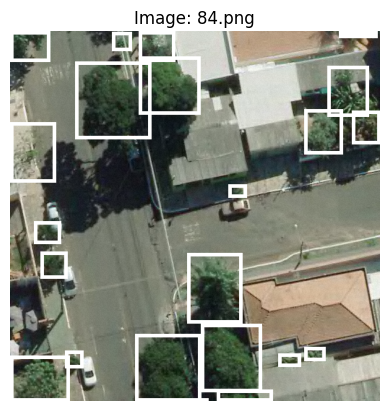

In [ ]:
name = "84" # Associate any image ... one that is in the training set

# Visualize a specific image by its ID
visualize_bounding_boxes_grouped(
    annotation_file="/content/dataset/annotations/instances_test.json",
    image_folder="/content/dataset/test/",
    specific_image_name=f"{name}.png"
)

To view, you must change "rtdetr_pytorch/tools/infer.py", as below (from 640x640 to 512x512).

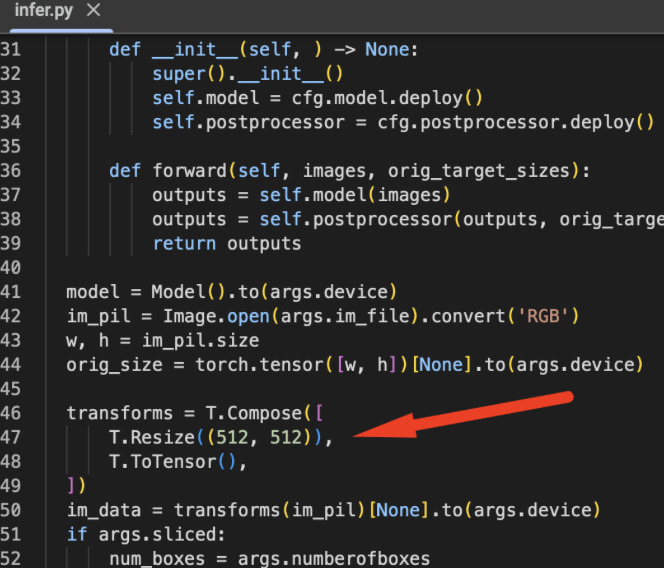

In [ ]:
# import subprocess

processed_image_path = "/content/dataset/test/84.png"

command = [
    "python", "/content/rtdetr_pytorch/tools/infer.py",
    "-c", "/content/rtdetr_pytorch/configs/rtdetr/rtdetr_r101vd_6x_coco.yml",
    "-r", "/content/analysis/rtdetr_r101vd_6x_coco_checkpoint.pth",
    "-f", processed_image_path,
    "-s", "True",
    "-d", "cuda",
    "-nc", "25"
]

try:
    subprocess.run(command, check=True, text=True, capture_output=True)
    print("Inference completed successfully!")
except subprocess.CalledProcessError as e:
    print(f"Error executing the command: {e}")
    print("Standard output (stdout):")
    print(e.stdout)
    print("Error output (stderr):")
    print(e.stderr)

Inference completed successfully!


In [ ]:
if execution_status == 4:
  !export CUDA_VISIBLE_DEVICES=0
  import os
  import shutil
  import zipfile
  import re
  import pandas as pd


  if use_augmentation:
    source_path_train = "with_augmentation_hvsr"  # with data augmentation
  else:
    source_path_train = "without_augmentation"  # with data augmentation

  # Source and destination paths
  source_path = f"/content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/results_train/{source_path_train}"
  destination_path = "/content/output"

  # List all files in the source directory
  files = os.listdir(source_path)

  # Filter .zip files
  zip_files = [file for file in files if file.endswith(".zip")]

  # ### if skipping certain training files ####
  # ignored_files = [
  #   "results_train_rtdetr_regnet_6x_coco_2024-12-15.zip",
  #    "results_train_rtdetr_r50vd_m_6x_coco_2024-12-15.zip",
  #   "results_train_rtdetr_r101vd_6x_coco-2024-12-15.zip",
  #    "results_train_rtdetr_r50vd_6x_coco_2024-12-15.zip",
  #    "results_train_rtdetr_r34vd_6x_coco_2024-12-15.zip",
  #    "results_train_rtdetr_r18vd_6x_coco_2024-12-15.zip",
  #   "results_train_rtdetr_dla34_6x_coco_2024-12-15.zip"
  # ]


  #Filter only .zip files that are not in the ignored list
  # zip_files = [file for file in files if file.endswith(".zip") and file not in ignored_files]
  ### end if skipping certain training files #####

  directory_path_analysis = "/content/analysis"
  os.makedirs(directory_path_analysis, exist_ok=True)

  !rm -rf /content/log.txt

  # Copy and extract each file
  for zip_file in zip_files:

      print(zip_file)
      # Ignore the file "analysis.zip"
      if os.path.basename(zip_file) == "analysis.zip":
        continue

      os.makedirs(destination_path, exist_ok=True)

      source_file = os.path.join(source_path, zip_file)
      destination_file = os.path.join(destination_path, zip_file)

      shutil.copy(source_file, destination_file)

      extract_path = os.path.join(destination_path, os.path.splitext(zip_file)[0])
      os.makedirs(extract_path, exist_ok=True)

      with zipfile.ZipFile(destination_file, 'r') as zip_ref:
          zip_ref.extractall(extract_path)

      print(f"File {source_path}/{zip_file} copied and extracted to {extract_path}")

      model_name = extract_model_name(extract_path)
      print("Model extracted:", model_name)

      process_log_and_extract_ap50(model_name, extract_path)

      start_directory = "/content/output"
      filename = "log.txt"
      file_path = find_file_in_directory(start_directory, filename)

      destination_directory = "/content/analysis"

      destination_file = f"{destination_directory}/{model_name}_log.txt"

      shutil.copy(file_path, destination_file)
      print(f"File copied to: {destination_file}")

      #test checkpoint.pth
      filename = "checkpoint.pth"
      file_path_checkpoint = find_file_in_directory(start_directory, filename)
      destination_file_checkpoint = f"{destination_directory}/{model_name}_{filename}"

      shutil.copy(file_path_checkpoint, destination_file_checkpoint)
      print(f"File copied to: {destination_file_checkpoint}")


      extract_train_loss(
        input_file_path=destination_file,
        backbone_name=model_name,
        output_file_path=f"/content/results/{model_name}_train_loss.csv"
      )

      result = extract_ap50_and_log(model_name, filename)
      #end test checkpoint.pth


      # #test checkpoint_best.pth
      # filename = "checkpoint_best.pth"
      # file_path_checkpoint = find_file_in_directory(start_directory, filename)
      # destination_file_checkpoint = f"{destination_directory}/{model_name}_{filename}"

      # shutil.copy(file_path_checkpoint, destination_file_checkpoint)
      # print(f"File copied to: {destination_file_checkpoint}")

      # extract_train_loss(
      #   input_file_path=destination_file,
      #   backbone_name=model_name,
      #   output_file_path=f"/content/results/{model_name}_train_loss.csv"
      # )


      result = extract_ap50_and_log(model_name, filename)
      #end test checkpoint.pth

      #csv_file_path = f"/content/analysis/{model_name}_ap50_results.csv"
      #plot_ap50_evolution(csv_file_path, model_name)

      !rm -rf /content/output

      #break


In [ ]:
if execution_status == 4:
  import pandas as pd

  def generate_overleaf_table(log_file_path, output_file_path):
      """
      Function to generate an Overleaf table in LaTeX format based on the log file.

      :param log_file_path: Path to the log file containing backbones and AP50 values.
      :param output_file_path: Path to save the generated LaTeX table.
      """
      # Model names mapping
      model_names_mapping = {
          "rtdetr_dla34_6x_coco": "DLA34",
          "rtdetr_r18vd_6x_coco": "ResNet18 (VD)",
          "rtdetr_r34vd_6x_coco": "ResNet34 (VD)",
          "rtdetr_r50vd_6x_coco": "ResNet50 (VD)",
          "rtdetr_r50vd_m_6x_coco": "ResNet50 Medium (VD)",
          "rtdetr_r101vd_6x_coco": "ResNet-101 (VD)",
          "rtdetr_regnet_6x_coco": "RegNet"
      }

      # Load the log data
      try:
          data = pd.read_csv(log_file_path, sep=";", header=None, names=["Backbone", "AP50"])
      except FileNotFoundError:
          print(f"File not found: {log_file_path}")
          return
      except Exception as e:
          print(f"Error loading the file: {e}")
          return

      # Map backbone names using the provided mapping
      data["Backbone"] = data["Backbone"].map(model_names_mapping).fillna(data["Backbone"])

      # Convert AP50 to numeric (handle any non-numeric errors)
      data["AP50"] = pd.to_numeric(data["AP50"], errors="coerce")

      # Remove rows with non-numeric values
      data = data.dropna(subset=["AP50"])

      # Find the row with the highest AP50
      max_row = data.loc[data["AP50"].idxmax()]

      # Start building the LaTeX table
      table = """\begin{table}[htbp]
  \centering
  \begin{tabular}{l r}
  \hline
  \textbf{Backbone} & \textbf{Test Set AP\textsubscript{50}}\\ \hline
  """

      # Add rows to the table
      for _, row in data.iterrows():
          backbone = row["Backbone"]
          ap50 = f"{row['AP50']:.3f}"
          if row["Backbone"] == max_row["Backbone"]:
              table += f"\\rowcolor{{gray!20}} {backbone} & {ap50} \\\\ \n"  # Highlight the best row
          else:
              table += f"{backbone} & {ap50} \\\\ \n"

      # Close the table
      table += """\hline
  \end{tabular}
  \caption{Performance of the backbones used with the RT-DETR method on the original dataset, without data augmentation, evaluated by AP$_{50}$.}
  \label{tab:ap50_without_augmentation}
  \end{table}"""

      # Save the table to the output file
      with open(output_file_path, "w") as file:
          file.write(table)

      print(f"LaTeX table saved at: {output_file_path}")

  generate_overleaf_table("/content/results/log.txt", "/content/results/tabela_overleaf.txt")

In [ ]:
if execution_status == 4:
    import os
    import json
    import matplotlib.pyplot as plt
    import seaborn as sns

    def extract_and_plot_train_loss_bbox(directory_path, show_values=False):
        """
        Reads all files in the specified directory with "*_log.txt" in the name,
        extracts train_loss_bbox values, and saves a line chart showing loss evolution.

        Args:
            directory_path (str): Path to the directory containing log files.
            show_values (bool): Whether to show values of each loss on the graph.
        """
        # Model names mapping
        model_names_mapping = {
            "rtdetr_dla34_6x_coco_log": "DLA34",
            "rtdetr_r18vd_6x_coco_log": "ResNet18 (VD)",
            "rtdetr_r34vd_6x_coco_log": "ResNet34 (VD)",
            "rtdetr_r50vd_6x_coco_log": "ResNet50 (VD)",
            "rtdetr_r50vd_m_6x_coco_log": "ResNet50 Medium (VD)",
            "rtdetr_r101vd_6x_coco_log": "ResNet-101 (VD)",
            "rtdetr_regnet_6x_coco_log": "RegNet"
        }

        # Check if the directory exists
        if not os.path.exists(directory_path):
            print(f"Error: The directory '{directory_path}' does not exist.")
            return

        # List all files matching the pattern "*_log.txt"
        log_files = [f for f in os.listdir(directory_path) if f.endswith('_log.txt')]

        if not log_files:
            print("No *_log.txt files found in the directory.")
            return

        # Initialize data for the plot
        backbone_data = {}

        # Iterate over each file and extract values
        for log_file in log_files:
            file_path = os.path.join(directory_path, log_file)
            backbone_key = os.path.splitext(log_file)[0]  # Backbone key (without extension)
            backbone_name = model_names_mapping.get(backbone_key, backbone_key)  # Map to readable name
            train_loss_bbox = []
            epochs = []

            with open(file_path, 'r') as file:
                for line in file:
                    try:
                        # Load each line as JSON
                        log_entry = json.loads(line)
                        # Check and store the train_loss_bbox value if it exists
                        if 'train_loss_bbox' in log_entry:
                            train_loss_bbox.append(log_entry['train_loss_bbox'])
                            epochs.append(log_entry.get('epoch', len(epochs)))
                    except json.JSONDecodeError:
                        continue  # Ignore lines that are not valid JSON

            # Store data for the plot
            if train_loss_bbox:
                backbone_data[backbone_name] = (epochs, train_loss_bbox)

        # Set a distinct color palette
        sns.set_palette("tab10")

        # Generate the plot
        plt.figure(figsize=(12, 8))
        for backbone, (epochs, losses) in backbone_data.items():
            plt.plot(epochs, losses, label=backbone, linewidth=2.5)

            if show_values:
                # Annotate each point with its loss value
                for epoch, loss in zip(epochs, losses):
                    plt.text(epoch, loss, f'{loss:.2f}', fontsize=8, ha='center', va='bottom')

        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.legend(fontsize=10, loc="upper right")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()

        # Save the plot
        save_path = '/content/results/loss.png'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        plt.close()  # Close the plot to free memory
        print(f"Plot saved to {save_path}")

    # Example usage
    directory = "/content/analysis"  # Replace with your path
    extract_and_plot_train_loss_bbox(directory, show_values=False)

In [ ]:
# name_result = "result_sem_data_augmentation.zip"
# zip_file_path = f"/content/{name_result}"
# !zip -r {zip_file_path} /content/results

# !cp /content/{name_result} /content/drive/MyDrive/Doutorado-UnB/PPGI0114/Projeto1/RT-DETR/results_train/without_augmentation/{name_result}